# Events and statistics from ROIs

This example illustrates the usage of regions of interest (ROIs) to capture statistics and interesting events from footage, under the assumption that the camera has a fixed position and orientation.

Contents:

1. Loading and displaying ROIs.
2. Counting objects inside ROIs.
3. Triggering interesting events.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from videoanalytics.pipeline import Pipeline
from videoanalytics.pipeline.sources import VideoReader
from videoanalytics.pipeline.sinks import VideoWriter

## Loading and displaying ROIs

### Configuration

#### Input and output video

We will be using the same video as in the previous examples.
Note: the video used in this example was downloaded from [youtube](https://www.youtube.com/watch?v=WgCe0tMO4lA).

In [127]:
DATA_PATH = "../data/"

# Input
INPUT_VIDEO = DATA_PATH+"/input/test_video.mp4"
START_FRAME = 10000
MAX_FRAMES = 1000

In [4]:
%%HTML
<div style="text-align: center">
    <video width="600" height="400" controls>
      <source src="../data/input/test_video.mp4" type="video/mp4">
    </video>
</div>

In [5]:
# Output
OUTPUT_VIDEO = DATA_PATH+ "/output/test_output.avi"

#### Definition of ROIs

In [11]:
ROI_DEFINITION_FILE= DATA_PATH+"/roi/mirtar.json"
!cat {ROI_DEFINITION_FILE}

{
	"regions": [
		{
			"name": "upper_left",
			"polygon": [[385, 315], [676, 334], [754, 625], [668, 810], [165, 757]],
			"color": [155,155,0]
		},

		{
			"name": "lower_left",
			"polygon": [[11, 532], [777, 606], [666, 1073], [5, 1074]],
			"color": [155,155,0]
		},

		{
			"name": "upper_right",
			"polygon": [[1057, 336], [908, 682], [954, 773], [1522, 754], [1565, 595], [1210, 305]],
			"color": [155,0,155]
		},

		{
			"name": "lower_right",
			"polygon": [[973, 1072], [949, 625], [1749, 538], [1904, 1068]],
			"color": [155,0,155]
		},


		{
			"name": "winch",
			"polygon": [[1088, 369], [592, 382], [570, 580], [1131, 584]],
			"color": [0,255,0]
		}
	]		
}

### Pipeline instantiation and execution

In [60]:
from videoanalytics.pipeline.sinks.roi import ROIView

In [61]:
# 1. Create the global context
context = {}

# 2. Create the pipeline
pipeline = Pipeline()

# 3. Add components

# 3.1 Source
pipeline.add_component( VideoReader( "input",context,
                 video_path=INPUT_VIDEO,
                 start_frame=START_FRAME,
                 max_frames=MAX_FRAMES))

In [62]:
# 3.2 ROI viewer
pipeline.add_component( ROIView("roi_view",context,filename=ROI_DEFINITION_FILE,alpha=0.6 ) )

In [73]:
# 3.3 Sink
pipeline.add_component(VideoWriter("writer",context,filename=OUTPUT_VIDEO))

In [74]:
# 4. Define connections
pipeline.set_connections([
    ("input", "roi_view"),
    ("roi_view", "writer")
])

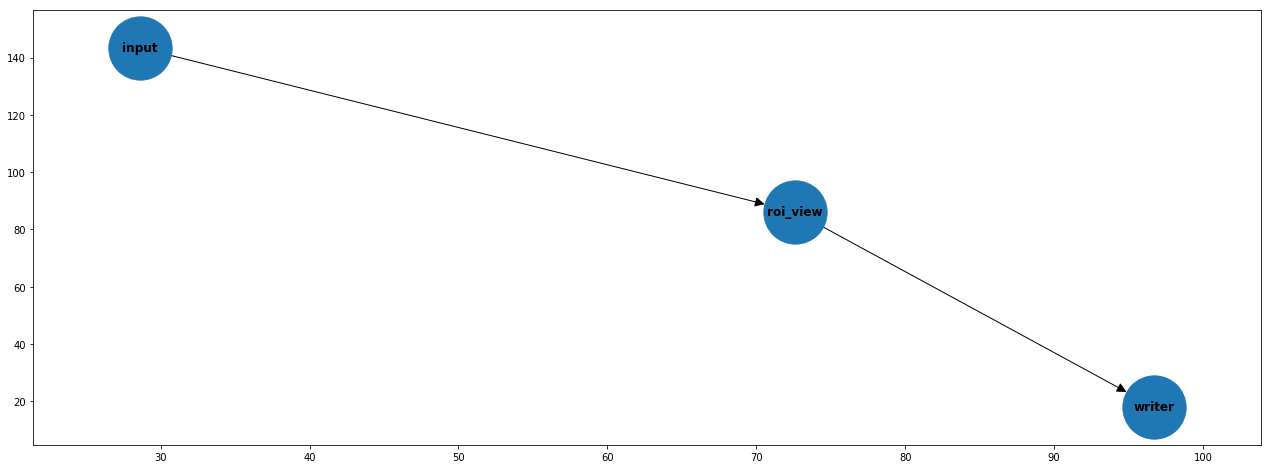

In [75]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(1,1,figsize=(22,8))
pipeline.plot(ax=axes)

In [66]:
# 5. Execute
pipeline.execute()
print("Total execution time [s]:", pipeline.get_total_execution_time())

  0%|          | 0/100.0 [00:00<?, ?it/s]

Total execution time [s]: 3.101937565996195


### Exploration of results

Display the output video with annotated bounding boxes.

Note: currently XVID format is not supported by jupyter.

In [52]:
%%HTML
<div style="text-align: center">
    <video width="600" height="400" controls>
      <source src="../data/output/test_output.avi" type="video/mp4">
    </video>
</div>

## A pipeline for counting objects inside ROIs

In [70]:
from videoanalytics.pipeline.sinks.roi import ROIPresenceCounter
from videoanalytics.pipeline.sinks.visualization import TextOverlay

In [71]:
# Specific components for object detection
from videoanalytics.pipeline.sinks.object_detection import DetectionsAnnotator, DetectionsCSVWriter
from videoanalytics.pipeline.sinks.object_detection.yolo4 import YOLOv4DetectorTF

In [72]:
# Detector

# Object Detector model weights (Tensorflow)
DETECTOR_WEIGHTS_FILENAME = DATA_PATH+ "object_detection/checkpoints/yolov4-416-tf"
#DETECTOR_WEIGHTS_FILENAME = DATA_PATH+ "object_detection/checkpoints/yolov4-tiny-416"


# Classes names for Detections Annotator
DETECTOR_CLASSES_FILENAME = DATA_PATH+"object_detection/classes_definitions/coco.txt"

# CSV with Detections filename
DETECTIONS_FILENAME = DATA_PATH+"/output/detections.csv"

### Pipeline instantiation and execution

In [128]:
# 1. Create the global context
context = {}

# 2. Create the pipeline
pipeline = Pipeline()

# 3. Add components

# 3.1 Source
pipeline.add_component( VideoReader( "input",context,
                 video_path=INPUT_VIDEO,
                 start_frame=START_FRAME,
                 max_frames=MAX_FRAMES))

# 3.2 Detector
pipeline.add_component( YOLOv4DetectorTF("detector",context,weights_filename=DETECTOR_WEIGHTS_FILENAME) )


# 3.3 Annotate detections in output video
pipeline.add_component( DetectionsAnnotator("annotator",context,
                                             class_names_filename=DETECTOR_CLASSES_FILENAME,
                                             show_label=True) )

# 3.4 ROI viewer
pipeline.add_component( ROIView("roi_view",context,filename=ROI_DEFINITION_FILE,alpha=0.6 ) )

# 3.5 ROI object counter
pipeline.add_component( ROIPresenceCounter("roi_counter",context,filename=ROI_DEFINITION_FILE) )

# 3.5 Display variables on display
pipeline.add_component( TextOverlay("stats_text",context, 
                                    text="Upper left: {q_upper_left}\n"
                                         "Lower left: {q_lower_left}\n"
                                         "Upper right: {q_upper_right}\n"
                                         "Lower right: {q_lower_right}\n"
                                         "Winch: {q_winch}\n"
                                         "Total: {q_total}",                                    
                                    x=10,y=40) )

# 3.6 Sink
pipeline.add_component(VideoWriter("writer",context,filename=OUTPUT_VIDEO))

# 4. Define connections
pipeline.set_connections([
    ("input", "detector"),        
    ("detector", "roi_counter"),
    ("detector", "annotator"),
    ("roi_counter", "roi_view"),
    ("roi_view", "annotator"),   
    ("annotator", "stats_text"),   
    ("stats_text", "writer")
])

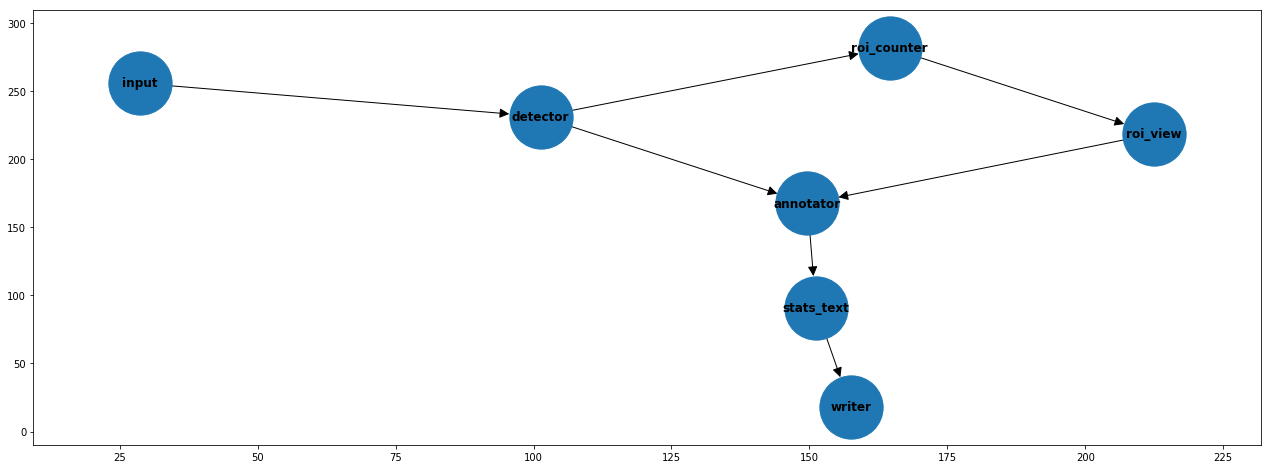

In [129]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(1,1,figsize=(22,8))
pipeline.plot(ax=axes)

In [130]:
# 5. Execute
pipeline.execute()
print("Total execution time [s]:", pipeline.get_total_execution_time())

  0%|          | 0/100.0 [00:00<?, ?it/s]

Total execution time [s]: 749.1805971910071


## A pipeline for triggering events from ROI activity

In [ ]:
#FIXME

### Pipeline instantiation and execution

In [ ]:
DEEPSORT_MODEL_FILENAME = DATA_PATH+"object_tracking/mars-small128.pb"

In [ ]:
from videoanalytics.pipeline.sinks.object_tracking.deepsort import DeepSORT

# 1. Create the global context
context = {}

# 2. Create the pipeline
pipeline = Pipeline()

# 3. Add components

# 3.1 Source
pipeline.add_component( VideoReader( "input",context,
                 video_path=INPUT_VIDEO,
                 start_frame=START_FRAME,
                 max_frames=MAX_FRAMES))

# 3.2 ROI viewer
pipeline.add_component( ROIView("roi_view",context,filename=ROI_DEFINITION_FILE,alpha=0.6 ) )

# 3.3 Detector
pipeline.add_component( YOLOv4DetectorTF("detector",context,weights_filename=DETECTOR_WEIGHTS_FILENAME) )

# 3.4 Tracker (DeepSORT)
pipeline.add_component( DeepSORT("tracker",context,model_filename=DEEPSORT_MODEL_FILENAME) )
pipeline.add_component( TrackedObjectsAnnotator("tracker_annotator",context) )

# 3.5 Sink
pipeline.add_component(VideoWriter("writer",context,filename=OUTPUT_VIDEO))

# 4. Define connections
pipeline.set_connections([
    ("input", "roi_view"),
    ("roi_view", "detector"),
    ("detector", "tracker"),
    ("tracker", "tracker_annotator"),
    ("tracker_annotator", "writer")
])

In [ ]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(1,1,figsize=(22,8))
pipeline.plot(ax=axes)

In [ ]:
# 5. Execute
pipeline.execute()
print("Total execution time [s]:", pipeline.get_total_execution_time())